In [1]:
import os, sys
import sys
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from  matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import librosa
import IPython.display as ipd
from numba import jit
sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c6
%matplotlib inline


### Noções Básicas e Premissas
Regularidades temporais e estruturais são talvez os incentivos mais importantes para que as pessoas se envolvam e interajam com a música. É o ritmo que impulsiona a música e fornece a estrutura temporal de uma peça musical. Intuitivamente, a batida corresponde ao pulso que uma pessoa bate ao ouvir música. A batida é frequentemente descrita como uma sequência de posições de pulso percebidas, que são tipicamente espaçadas igualmente no tempo e especificadas por dois parâmetros: a fase e o período. O termo tempo refere-se à taxa do pulso e é dado pelo recíproco do período da batida. 

A extração de informações de tempo e ritmo a partir de gravações de áudio é um problema desafiador, especialmente para músicas com inícios de notas fracos e mudanças locais de tempo. Por exemplo, no caso da música de piano romântica, o pianista frequentemente toma a liberdade de acelerar e desacelerar o tempo — um meio artístico também referido como **tempo rubato**. Existe uma ampla gama de músicas onde as noções de tempo e ritmo permanecem bastante vagas ou são até inexistentes. Às vezes, o fluxo rítmico da música é deliberadamente interrompido ou perturbado pela sincopação, onde certas notas fora da grade regular das posições de batida são enfatizadas.

Para tornar o problema de rastreamento de tempo e ritmo viável, a maioria das abordagens automatizadas baseia-se em duas suposições básicas.

- A primeira suposição é que as posições de ritmo ocorrem nas posições de início das notas.
- A segunda suposição é que as posições de ritmo são mais ou menos igualmente espaçadas — pelo menos por um certo período de tempo.

Embora ambas as suposições possam ser violadas e inapropriadas para certos tipos de música, elas são convenientes e razoáveis para uma ampla gama de músicas, incluindo a maioria das canções de rock e músicas populares.

### Representações de Tempograma

Em análise de Fourier, um espectrograma (de magnitude) é uma representação tempo-frequência de um dado sinal. Um valor grande $Y(t, \omega)$ de um espectrograma indica que o sinal contém, no instante $t$, um componente periódico que corresponde à frequência $\omega$. Agora, introduzimos um conceito semelhante, denominado tempograma, que indica, para cada instante de tempo, a relevância local de um tempo específico para uma determinada gravação musical. Matematicamente, modelamos um tempograma como uma função
$$T : \mathbb{R} \times \mathbb{R}_{>0} \to \mathbb{R}_{\geq 0}$$
dependendo de um parâmetro de tempo $t \in \mathbb{R}$ medido em segundos e um parâmetro de tempo $\tau \in \mathbb{R}_{>0}$ medido em batidas por minuto (BPM). Intuitivamente, o valor $T(t, \tau)$ indica a extensão em que o sinal contém um pulso periódico local de um dado tempo $\tau$ em uma vizinhança do instante de tempo $t$. Assim como nos espectrogramas, um tempograma é calculado na prática apenas em uma grade de **tempo-tempo** discreta. Como antes, assumimos que o eixo de tempo amostrado é dado por $[1:N]$. Para evitar casos de fronteira e simplificar a notação nas considerações subsequentes, estendemos esse eixo para $\mathbb{Z}$. Além disso, seja $\Theta \subset \mathbb{R}_{>0}$ um conjunto finito de tempos especificados em BPM. Então, um tempograma discreto é uma função
$$T : \mathbb{Z} \times \Theta \to \mathbb{R}_{\geq 0}.$$
A maioria das abordagens para derivar uma representação de tempograma a partir de uma gravação de áudio procede em duas etapas.

- Com base na suposição de que as posições dos pulsos geralmente acompanham os inícios das notas, o sinal musical é primeiro convertido em uma função de novidade. Esta função tipicamente consiste em picos impulsivos, cada um indicando uma posição de início de nota.
- Na segunda etapa, o comportamento periódico local da função de novidade é analisado.

Para obter um tempograma, quantifica-se o comportamento periódico para vários períodos $T>0$ (dados em segundos) em uma vizinhança de um determinado instante de tempo. A taxa $\omega = 1/T$ (medida em Hz) e o tempo $\tau$ (medido em BPM) estão relacionados por
$$\tau = 60 \cdot \omega.$$
Por exemplo, uma sequência de picos impulsivos que estão regularmente espaçados com um período $T = 0.5$ segundos corresponde a uma taxa de $\omega = 1/T = 2$ Hz ou a um tempo de $\tau = 120$ BPM.

### Níveis de Pulso

Um dos principais problemas na determinação do tempo de uma gravação musical surge do fato de que os pulsos na música frequentemente são organizados em hierarquias complexas que representam o ritmo. Em particular, existem vários níveis que se presume contribuir para a percepção humana do tempo e do ritmo. O nível de **tactus** normalmente corresponde ao nível de semínima e frequentemente coincide com a taxa de batida do pé. Pensando em uma escala musical maior, pode-se também perceber o tempo ao nível da medida, especialmente ao ouvir música rápida ou música altamente expressiva com forte **rubato**. Finalmente, pode-se também considerar o nível de tatum (átomo temporal), que se refere à taxa de repetição mais rápida de acentos musicalmente significativos que ocorrem no sinal.

### Oitava de Tempo, Harmônico e Sub-harmônico

Frequentemente, a ambiguidade do tempo que surge da existência de diferentes níveis de pulso também se reflete em um tempograma $T$. Níveis de pulso mais altos frequentemente correspondem a múltiplos inteiros $\tau, 2\tau, 3\tau, \ldots$ de um dado tempo $\tau$. Assim como com a altura tonal, chamamos esses múltiplos inteiros de **harmônicos (de tempo)** de $\tau$. Além disso, frações inteiras $\tau, \tau/2, \tau/3, \ldots$ são referidas como **sub-harmônicos (de tempo)** de $\tau$. Análogo à noção de uma oitava para alturas musicais, a diferença entre dois tempos com metade ou o dobro do valor é chamada de oitava de tempo.

### Tempo Global

Assumindo um tempo mais ou menos constante, basta determinar um valor de tempo global para toda a gravação. Esse valor pode ser obtido pela média dos valores de tempo obtidos a partir de uma análise de periodicidade quadro a quadro. Por exemplo, com base em uma representação de tempograma, pode-se fazer a média dos valores de tempo ao longo de todos os quadros temporais para obter uma função $T_{Average} : \Theta \to \mathbb{R}_{\geq 0}$ que depende apenas de $\tau \in \Theta$. Assumindo que as posições temporais relevantes estejam no intervalo $[1:N]$, pode-se definir $T_{Average}$ por
$$T_{Average}(\tau) := \frac{1}{N} \sum_{n \in [1:N]} T(n, \tau)$$

O máximo

$$\hat{\tau} := \max \{ T_{Average}(\tau) \mid \tau \in \Theta \}$$

dessa função então fornece uma estimativa para o tempo global da gravação. É claro que métodos mais refinados para estimar um único valor de tempo podem ser aplicados. Por exemplo, em vez de usar uma média simples, pode-se aplicar uma filtragem de mediana, que é mais robusta a outliers e ruídos.

# tempograma de Fourier
### Definição
Assumimos que nos é dada uma função de novidade discreta $\Delta : \mathbb{Z} \to \mathbb{R}$ na qual os picos indicam candidatos a início de notas. A ideia da análise de Fourier é detectar periodicidades localmente no sinal comparando-o com janelas senoidais. Uma alta correlação de uma seção local de $\Delta$ com uma janela senoidal indica uma periodicidade da frequência da senóide (dada uma fase adequada). Essa correlação (ao longo da fase) pode ser calculada usando uma transformada de Fourier de curto prazo (FFT). Para isso, fixamos uma função de janela $w : \mathbb{Z} \to \mathbb{R}$ de comprimento finito centrada em $n = 0$ (por exemplo, uma janela de Hann). Então, para um parâmetro de frequência $\omega \in \mathbb{R}_{\geq 0}$ e um parâmetro de tempo $n \in \mathbb{Z}$, o coeficiente de Fourier $F_\Delta(n, \omega)$ é definido por

$$F_\Delta(n, \omega) := \sum_{m \in \mathbb{Z}} \Delta(m) w(m - n) \exp(-2\pi i \omega m).$$

Essa definição é similar a uma transformada discreta de Fourier de curto prazo quando se usa um tamanho de hop $H = 1$. Convertendo a frequência para valores de tempo, definimos o tempograma de Fourier (discreto) $\mathcal{T}^F : \mathbb{Z} \times \Theta \to \mathbb{R}_{\geq 0}$ como

$$\mathcal{T}^F(n, \tau) := |F_\Delta(n, \tau/60)|.$$

Para aplicações práticas, $\mathcal{T}^F$ é calculado apenas para um pequeno número de parâmetros de tempo. Por exemplo, pode-se escolher o conjunto $\Theta = [30 : 600]$ cobrindo a gama de tempos musicais (inteiros) entre $30$ BPM e $600$ BPM. Essas escolhas são motivadas pela suposição de que apenas eventos musicais com uma separação temporal entre aproximadamente $100$ msec ($600$ BPM) e $2$ sec ($30$ BPM) contribuem para a percepção do tempo. Dependendo da aplicação específica e da natureza do sinal musical, uma janela que cobre de $4$ a $12$ segundos de áudio é uma faixa razoável. Além disso, a taxa de amostragem da função de novidade resultante pode ser ajustada introduzindo um parâmetro de hop $H$.

### Resolução do Tempo

Usar um conjunto de tempo como $\Theta = [30 : 600]$ requer uma análise espectral de alta resolução — em particular na faixa de frequência mais baixa. Por exemplo, assumimos que a função de novidade de entrada $\Delta$ tem uma taxa de amostragem de recurso $F_\Delta^A = 100$ Hz e que o comprimento da janela $w$ é $N = 1000$ (cobrindo 10 segundos da função de novidade $\Delta$). Então, simplesmente aplicando uma DFT de tamanho $N$, obteríamos os coeficientes de Fourier correspondentes às frequências físicas

$$\omega = F_{\text{coef}}(k) = \frac{k \cdot F_\Delta^A}{N} = k \cdot 0.1 \text{ Hz}$$

para $k \in [0 : 500]$, o que corresponde aos tempos $\tau = k \cdot 6$ BPM. Em outras palavras, a DFT renderia uma resolução de tempo de $6$ BPM com valores de tempo variando de $\tau = 0$ até $\tau = 3000$ BPM. Se estamos interessados em um conjunto de tempos específico como $\Theta = [30 : 600]$, apenas uma pequena fração dos coeficientes de Fourier (com $k \in [5 : 100]$) é necessária. Além disso, a resolução do tempo de $6$ BPM não é suficiente. Portanto, uma STFT direta baseada na DFT pode não ser adequada. Uma alternativa é computar os coeficientes de Fourier requeridos individualmente (sem usar a DFT). Mesmo que isso não possa ser feito via a abordagem DFT, a complexidade computacional pode ainda ser razoável uma vez que apenas um número relativamente pequeno de coeficientes de Fourier (correspondendo ao conjunto de tempos $\Theta$) precisa ser computado.

### Implementação

Abaixo, fornecemos uma implementação que está próxima da fórmula

$$F_\Delta(n, \omega) := \sum_{m \in \mathbb{Z}} \Delta(m) w(m - n) \exp(-2\pi i \omega m).$$

Assume-se que a função de novidade $\Delta$ tem comprimento $L \in \mathbb{N}$. Como função de janela $w$, escolhemos uma janela de Hann de comprimento $N \in \mathbb{N}$, que é deslocada pelo parâmetro de hop $H \in \mathbb{N}$. Seguindo, usamos uma visão centralizada, onde a função de novidade possa por zero-padding pela metade do comprimento da janela. Como resultado, o primeiro quadro $F_\Delta$ indexado por $n = 0$ corresponde ao tempo físico $t = 0$ seg. Note que o parâmetro de hop $H$ reduz a taxa de quadro do tempograma para $F_\Delta^A / H$ por segundo. Como pode-se ver, escolhemos qualquer conjunto finito de $\tau$ que nossa análise abranja um laço externo iterando sobre $\tau \in \Theta$. Para cada frequência $\omega = \tau/60$, os valores $F_\Delta(n, \omega)$ são então computados por um laço interno iterando sobre os índices de quadro $n$.

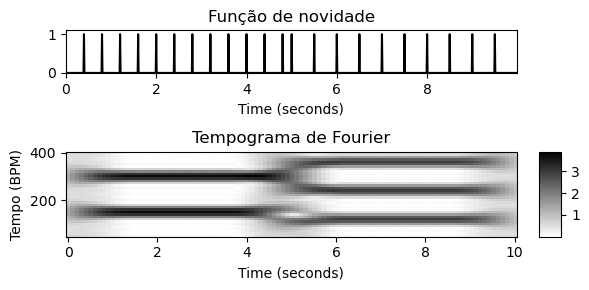

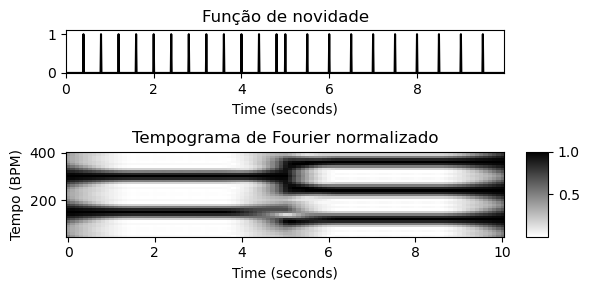

In [2]:
@jit(nopython=True)
def compute_tempogram_fourier(x, Fs, N, H, Theta=np.arange(30, 601, 1)):
    """ Computa o tempograma baseado em Fourier
    Args:
        x (np.ndarray): Sinal de entrada
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
        Theta (np.ndarray): Conjunto de tempo (dado em BPM) (Valor padrão = np.arange(30, 601, 1))
    Return:
        X (np.ndarray): Tempograma
        T_coef (np.ndarray): Eixo temporal (segundos)
        F_coef_BPM (np.ndarray): Eixo de tempos (BPM) """
    # Cria a janela de Hann
    win = np.hanning(N)
    N_left = N // 2
    L = x.shape[0]
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    
    # Cria uma versão "padded" do sinal de entrada
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    t_pad = np.arange(L_pad)
    
    # Calcula o número de segmentos que serão extraídos do sinal "padded"
    M = int(np.floor(L_pad - N) / H) + 1
    
    # Número de diferentes tempo (BPM) a serem analisados
    K = len(Theta)
    
    # Inicializa o tempograma como uma matriz de zeros complexos
    X = np.zeros((K, M), dtype=np.complex_)

    # Loop para cada tempo (BPM)
    for k in range(K):
        # Calcula a frequência angular correspondente ao tempo (BPM)
        omega = (Theta[k] / 60) / Fs
        # Cria uma exponencial complexa para modulação de frequência
        exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
        # Modula o sinal "padded" pela exponencial
        x_exp = x_pad * exponential
        
        # Loop para cada segmento de tempo
        for n in range(M):
            t_0 = n * H
            t_1 = t_0 + N
            # Calcula a soma ponderada pela janela do segmento modulado
            X[k, n] = np.sum(win * x_exp[t_0:t_1])

    # Cria o eixo temporal em segundos
    T_coef = np.arange(M) * H / Fs
    # Usa os tempos fornecidos como o eixo de BPM
    F_coef_BPM = Theta
    
    return X, T_coef, F_coef_BPM


# A curva consiste em uma faixa de clique, que tem um tempo de 150 BPM em sua primeira metade e um tempo de 120 BPM em sua segunda metade.
Fs = 100
L = 10*Fs
x = np.zeros(L)
peaks = np.concatenate((np.arange(40,L//2,40),np.arange(500,L,50)))
x[peaks]=1
N = 300
H = 10
Theta = np.arange(50,410,10)

X, T_coef, F_coef_BPM = compute_tempogram_fourier(x, Fs, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6, 3))        
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], color='k', title='Função de novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True);
plt.tight_layout()

X, T_coef, F_coef_BPM = compute_tempogram_fourier(x, Fs, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)
tempogram = libfmp.c3.normalize_feature_sequence(tempogram, norm='max')
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6, 3))        
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], color='k', title='Função de novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier normalizado', ylabel='Tempo (BPM)', colorbar=True);
plt.tight_layout()


A visualização do tempograma de Fourier $\mathcal{T}^F$ revela o tempo dominante ao longo do tempo. De fato, há valores altos para $\tau = 150$ BPM nos primeiros cinco segundos e valores altos para o tempo $\tau = 120$ BPM nos últimos cinco segundos. Baseado em uma análise de Fourier, uma entrada $\mathcal{T}^F(n, \tau)$ é obtida comparando localmente a função de novidade $\Delta$ em uma vizinhança de $n$ com uma sinusoide em janela que representa o tempo $\tau$ (ou a frequência $\omega = \tau / 60$).

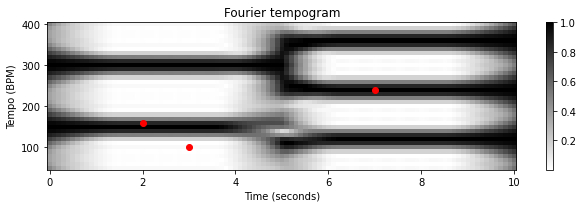

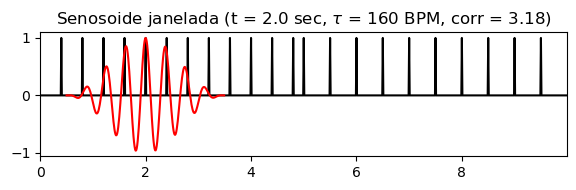

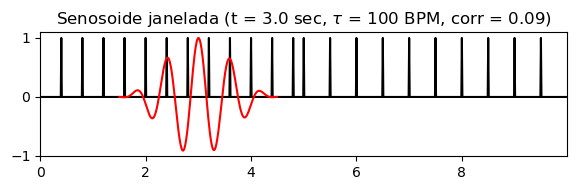

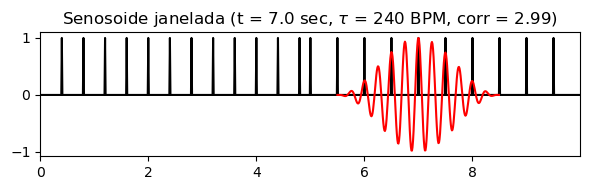

In [3]:
def compute_sinusoid_optimal(c, tempo, n, Fs, N, H):
    """ Calcula a sinusóide "janelada" e fase ótima
    Args:
        c (complex): Coeficiente do tempograma (c=X(k,n))
        tempo (float): Parâmetro de tempo correspondente a c (tempo=F_coef_BPM[k])
        n (int): Parâmetro de frame de c
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
    Retorna:
        kernel (np.ndarray): Sinusóide com janela aplicada
        t_kernel (np.ndarray): Eixo temporal (amostras) do kernel
        t_kernel_sec (np.ndarray): Eixo temporal (segundos) do kernel """
    # Aplica a janela de Hann
    win = np.hanning(N)
    N_left = N // 2
    omega = (tempo / 60) / Fs
    t_0 = n * H
    t_1 = t_0 + N
    # Calcula a fase ótima
    phase = - np.angle(c) / (2 * np.pi)
    t_kernel = np.arange(t_0, t_1)
    # Calcula a sinusóide com a fase ótima
    kernel = win * np.cos(2 * np.pi * (t_kernel*omega - phase))
    # Converte o eixo temporal para segundos
    t_kernel_sec = (t_kernel - N_left) / Fs
    return kernel, t_kernel, t_kernel_sec

def plot_signal_kernel(x, t_x, kernel, t_kernel, xlim=None, figsize=(6, 2), title=None):
    """ Plota o sinal e o kernel local
    Args:
        x: Sinal
        t_x: Eixo temporal de x (dado em segundos)
        kernel: Kernel local
        t_kernel: Eixo temporal do kernel (dado em segundos)
        xlim: Limites para o eixo x (Valor padrão = None)
        figsize: Tamanho da figura (Valor padrão = (8, 2))
        title: Título da figura (Valor padrão = None)
    Retorna:
        fig: Matplotlib handle da figura
    """
    if xlim is None:
        xlim = [t_x[0], t_x[-1]]
    fig = plt.figure(figsize=figsize)
    plt.plot(t_x, x, 'k')
    plt.plot(t_kernel, kernel, 'r')
    plt.title(title)
    plt.xlim(xlim)
    plt.tight_layout()
    return fig

t_x = np.arange(x.shape[0])/Fs
coef_n = [20, 30, 70]
coef_k = [11, 5, 19]

fig, ax, im = libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, figsize=(9,3), title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True);
ax[0].plot(T_coef[coef_n],F_coef_BPM[coef_k],'ro')
for i in range(len(coef_k)):
    k = coef_k[i]
    n = coef_n[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    corr = np.abs(X[k,n])
    kernel, t_kernel, t_kernel_sec = compute_sinusoid_optimal(X[k,n], F_coef_BPM[k], n, Fs, N, H)
    title=r'Senosoide janelada (t = %0.1f sec, $\tau$ = %0.0f BPM, corr = %0.2f)'%(time, tempo, corr)
    fig = plot_signal_kernel(x, t_x, kernel, t_kernel_sec,title=title)
plt.tight_layout()

Para o primeiro par de tempo ( $t = 2$ seg e $\tau = 160$ BPM ), as partes positivas do senoide com janela se alinham bem com os picos da função de novidade $\Delta$, enquanto as partes negativas do senoide caem nas regiões de zero de $\Delta$. Como resultado, há uma alta correlação entre o senoide com janela e $\Delta$, o que leva a um grande coeficiente $ \mathcal{T}^F (n, \tau)$.

Para o segundo par ( $t = 3$ , $\tau = 100$ ), o senoide leva a um coeficiente pequeno. Neste caso, alguns picos de $\Delta$ caem nas partes positivas do senoide, enquanto outros picos caem nas partes negativas do senoide. Devido às cancelamentos resultantes, a correlação geral entre $\Delta$ e o senoide é pequena.

Finalmente, no terceiro par ( $t = 7$ , $\tau = 240$ ) se obtém uma alta correlação ao usar um senoide que representa o dobro do tempo principal. Neste caso, os picos de $\Delta$ estão alinhados com cada segundo parte positiva do senoide, enquanto todas as outras partes do senoide caem nas regiões de zero de $\Delta$.
Geralmente tempograma de Fourier indica harmônicos de tempo, mas suprime sub-harmônicos de tempo.

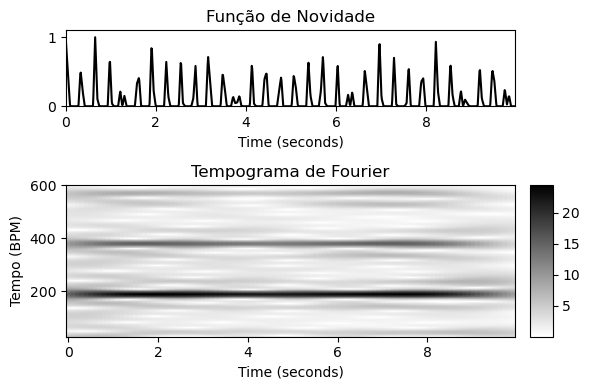

In [4]:
fn_wav = os.path.join( 'Audios', 'Luv(sic)_Part_3.mp3')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=4096, H=1024, gamma=100, M=10,norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6,4))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Função de Novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,4));
plt.tight_layout()

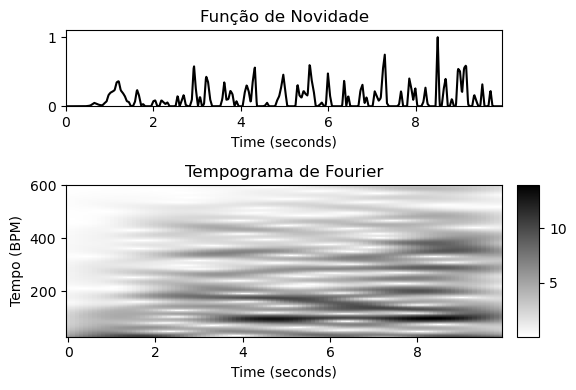

In [5]:
fn_wav = os.path.join( 'Audios', 'Friends_Yuki_Hayashi.wav')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_energy(x, Fs=Fs, N=4096, H=1024, gamma=1, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6,4))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Função de Novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True, figsize=(6,4));
plt.tight_layout()

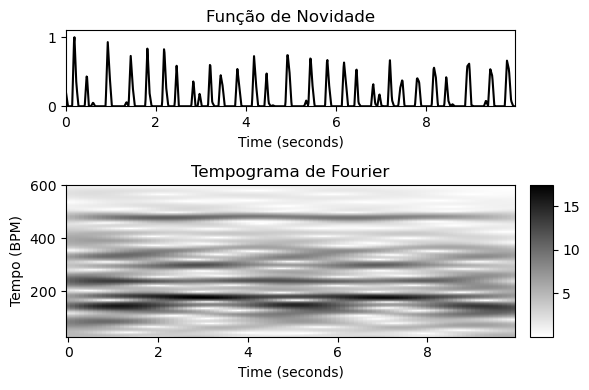

In [6]:
fn_wav = os.path.join( 'Audios', 'Friends_Yuki_Hayashi.wav')
x, Fs = librosa.load(fn_wav)
x = x[Fs * 25:Fs * 35]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=4096, H=1024, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6,4))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Função de Novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,4));
plt.tight_layout()


# Tempograma de Autocorrelação

### autocorrelação

Em termos gerais, a autocorrelação é uma ferramenta matemática para medir a semelhança de um sinal com uma versão deslocada no tempo de si mesma. Seja $x: \mathbb{Z} \rightarrow \mathbb{R}$ um sinal discreto no tempo com energia finita. A autocorrelação $R_{xx}: \mathbb{Z} \rightarrow \mathbb{R}$ do sinal real $x$ é definida por:

$$R_{xx}(\ell) = \sum_{m \in \mathbb{Z}} x(m) x(m - \ell)$$

o que produz uma função que depende do parâmetro de deslocamento temporal ou defasagem $\ell \in \mathbb{Z}$. A autocorrelação $R_{xx}(\ell)$ é máxima para $\ell = 0$ e simétrica em relação a $\ell$. Intuitivamente, se a autocorrelação é grande para um determinado deslocamento, então o sinal contém padrões repetidos que estão separados por um período de tempo especificado pelo parâmetro de defasagem.

No exemplo a seguir, consideramos um sinal que consiste em dois padrões de clique: um com período 9 e outro com período 14. A autocorrelação tem trivialmente um pico no deslocamento $\ell = 0$ (o sinal é semelhante a si mesmo), depois em $\ell = 9$ (primeiro período), $\ell = 14$ (segundo período), $\ell = 18$ (duas vezes o primeiro período), $\ell = 27$ (três vezes o primeiro e, em $\ell = 28$, duas vezes o segundo período), e assim por diante. Em particular, se a autocorrelação tem um pico no deslocamento $\ell$, então ela também tem picos em inteiros.

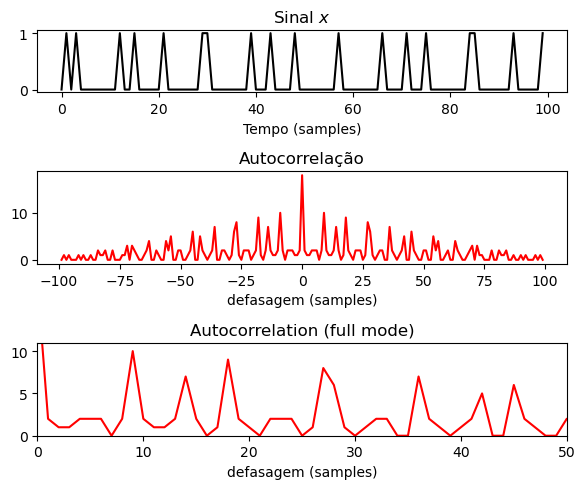

In [7]:
N = 100
x = np.zeros(N)
x[np.arange(1,N,14)] = 1
x[np.arange(3,N,9)] = 1

fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1.5, 1.5]}, figsize=(6, 5))       

ax[0].plot(x, 'k')
ax[0].set_title('Sinal $x$')
ax[0].set_xlabel('Tempo (samples)')

r_xx = np.correlate(x, x, mode='full')
lag_axis = np.arange(-(N-1),N)
ax[1].plot(lag_axis,r_xx, 'r')
ax[1].set_title('Autocorrelação')
ax[1].set_xlabel(r'defasagem (samples)')

r_xx = np.correlate(x, x, mode='full')
lag_axis = np.arange(-(N-1),N)
ax[2].plot(lag_axis,r_xx, 'r')
ax[2].set_title('Autocorrelation (full mode)')
ax[2].set_xlabel(r'defasagem (samples)')
ax[2].set_xlim([0,50])
ax[2].set_ylim([0,11])

plt.tight_layout()

### Autocorrelação de curto prazo

Agora aplicamos a autocorrelação de forma local para analisar uma função de novidade dada $\Delta: \mathbb{Z} \rightarrow \mathbb{R}$ nas proximidades de um parâmetro de tempo $n$ dado. Para isso, fixamos uma função de janela $w: \mathbb{Z} \rightarrow \mathbb{R}$. A versão com janela $\Delta_{w,n}: \mathbb{Z} \rightarrow \mathbb{R}$ localizada no ponto $n \in \mathbb{Z}$ é definida por:

$$\Delta_{w,n}(m) := \Delta(m) \cdot w(m - n)$$

onde $m \in \mathbb{Z}$. Para obter a autocorrelação de curto prazo $A: \mathbb{Z} \times \mathbb{Z} \rightarrow \mathbb{R}$, calculamos a autocorrelação de $\Delta_{w,n}$:

$$A(n, \ell) := \sum_{m \in \mathbb{Z}} \Delta(m) \cdot w(m - n) \cdot \Delta(m - \ell) \cdot w(m - n - \ell)$$

Aqui, assumimos que a função de janela $w: [0: N-1] \rightarrow \mathbb{R}$ tem comprimento finito $N \in \mathbb{N}$. (Como de costume, por conveniência matemática, pode-se estender $w$ por zero fora do intervalo $[0: N-1]$.) Então, a autocorrelação da função de novidade localizada é zero para todos os parâmetros de defasagem temporais exceto para um número finito. Mais precisamente, pode-se mostrar que $A(n, \ell) = 0$ para $|\ell| > N$. Devido a essa propriedade e à simetria da autocorrelação, só precisamos considerar os parâmetros de defasagem temporal $\ell \in [0: N-1]$. Além disso, devido à janelamento, no máximo $N-\ell$ dos termos da soma são diferentes de zero. Para equilibrar o efeito do janelamento, o valor $A(n, \ell)$ pode ser dividido por um fator que depende das propriedades da janela e da sobreposição $N-\ell$ da janela e sua versão deslocada no tempo. Visualizar a autocorrelação de curto prazo $A$ leva a uma representação de tempo-defasagem com um parâmetro de quadro $n \in \mathbb{Z}$ e um parâmetro de defasagem $\ell \in [0: N-1]$.

### Implementação:
Assume-se que a curva de novidade $\Delta$ tem comprimento $L \in \mathbb{N}$ com uma taxa de amostragem $F_{\Delta s}$. Como função de janela $w$, escolhemos uma janela retangular de comprimento $N \in \mathbb{N}$. Além disso, introduzimos um parâmetro de tamanho de salto $H \in \mathbb{N}$. Usamos uma visualização centralizada, onde a função de novidade é preenchida com zeros pela metade do comprimento da janela. Como resultado, o primeiro quadro de $A$ indexado por $n = 0$ corresponde à posição temporal física $t = 0$ segundos. Além disso, o parâmetro de tamanho de salto $H$ reduz a taxa de quadros do tempograma para $F_{\Delta s} / H4. O algoritmo percorre os índices de quadros $n$ e calcula $A(n, \ell)$ para todos $\ell \in [0: N-1]$ usando uma única autocorrelação.

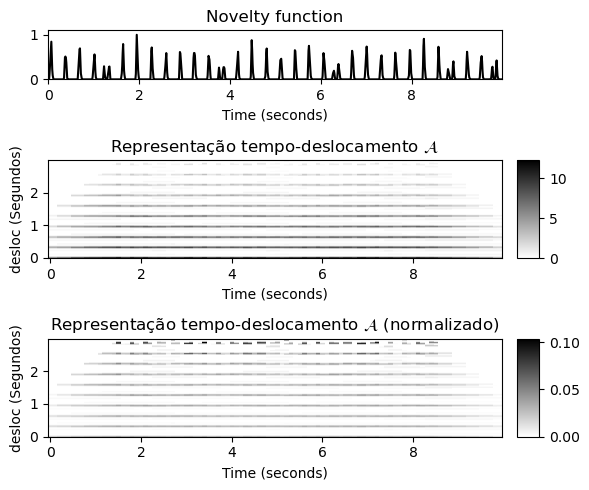

In [8]:
def compute_autocorrelation_local(x, Fs, N, H, norm_sum=True):
    """ Calcula a autocorrelação local
    Args:
        x (np.ndarray): Sinal de entrada
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
        norm_sum (bool): Normaliza pelo número de parcelas na autocorrelação local (Valor padrão = True)
    Retorna:
        A (np.ndarray): Representação do atraso temporal
        T_coef (np.ndarray): Eixo temporal (segundos)
        F_coef_lag (np.ndarray): Eixo de atraso """
    # Calcula o tamanho do padding à esquerda e à direita
    L_left = round(N / 2)
    L_right = L_left
    # Adiciona zero-padding ao sinal
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    L_pad = len(x_pad)
    # Calcula o número de segmentos que serão extraídos do sinal "padded"
    M = int(np.floor(L_pad - N) / H) + 1
    # Inicializa a matriz para armazenar os resultados da autocorrelação local
    A = np.zeros((N, M))
    # Define a janela utilizada na análise (neste caso, uma janela retangular)
    win = np.ones(N)
    # Calcula o vetor de soma de parcelas de atraso, se a normalização for ativada
    if norm_sum is True:
        lag_summand_num = np.arange(N, 0, -1)
    
    # Loop sobre cada segmento do sinal
    for n in range(M):
        t_0 = n * H
        t_1 = t_0 + N
        # Extrai o segmento local do sinal
        x_local = win * x_pad[t_0:t_1]
        # Calcula a autocorrelação local utilizando a função np.correlate
        r_xx = np.correlate(x_local, x_local, mode='full')
        r_xx = r_xx[N-1:]  # Mantém apenas a parte relevante do resultado da correlação
        # Normaliza a autocorrelação local pelo número de parcelas, se necessário
        if norm_sum is True:
            r_xx = r_xx / lag_summand_num
        # Armazena o resultado na matriz de autocorrelação local
        A[:, n] = r_xx
    
    # Calcula a taxa de amostragem do eixo temporal da autocorrelação local
    Fs_A = Fs / H
    # Cria o eixo temporal em segundos
    T_coef = np.arange(A.shape[1]) / Fs_A
    # Cria o eixo de atraso, representado em unidades de tempo
    F_coef_lag = np.arange(N) / Fs
    
    return A, T_coef, F_coef_lag

fn_wav = os.path.join( 'Audios', 'Luv(sic)_Part_3.mp3')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=1)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 300
H = 10
A, T_coef, F_coef_lag = compute_autocorrelation_local(nov, Fs_nov, N, H, norm_sum=False)
A_norm, T_coef, F_coef_lag = compute_autocorrelation_local(nov, Fs_nov, N, H)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2, 2]}, figsize=(6,5))        

libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()

libfmp.b.plot_matrix(A, ax=[ax[1,0], ax[1,1]], T_coef=T_coef, F_coef=F_coef_lag, title=r'Representação tempo-deslocamento $\mathcal{A}$', ylabel='desloc (Segundos)', colorbar=True);
libfmp.b.plot_matrix(A_norm, ax=[ax[2,0], ax[2,1]], T_coef=T_coef, F_coef=F_coef_lag, title=r'Representação tempo-deslocamento $\mathcal{A}$ (normalizado)', ylabel='desloc (Segundos)', colorbar=True);
plt.tight_layout()

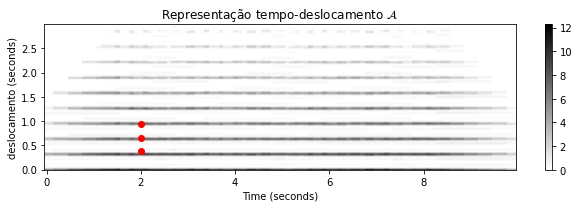

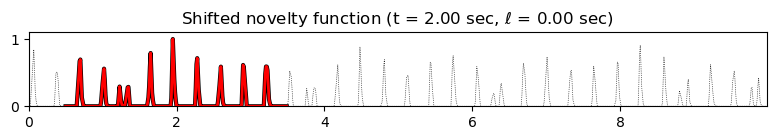

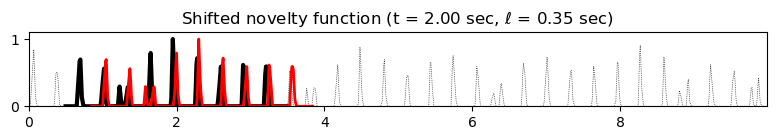

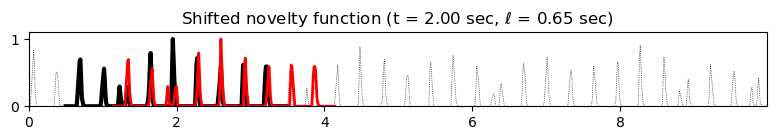

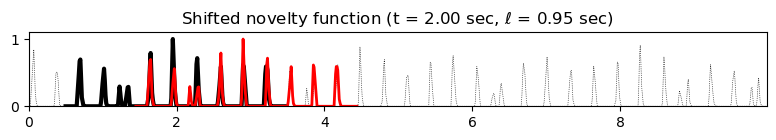

In [9]:
def plot_signal_local_lag(x, t_x, local_lag, t_local_lag, lag, xlim=None, figsize=(8, 1.5), title=''):
    """ Visualiza o sinal e o atraso local
    Args:
        x: Sinal
        t_x: Eixo temporal de x (dado em segundos)
        local_lag: Atraso local
        t_local_lag: Eixo temporal do atraso local (dado em segundos)
        lag: Atraso (dado em segundos)
        xlim: Limites para o eixo x (Valor padrão = None)
        figsize: Tamanho da figura (Valor padrão = (8, 1.5))
        title: Título da figura (Valor padrão = '')
    Returns:
        fig: Handle da figura Matplotlib """
    if xlim is None:
        xlim = [t_x[0], t_x[-1]]
    fig = plt.figure(figsize=figsize)
    # Plota o sinal com linha tracejada
    plt.plot(t_x, x, 'k:', linewidth=0.5)
    # Plota o atraso local
    plt.plot(t_local_lag, local_lag, 'k', linewidth=3.0)
    # Plota o atraso local deslocado
    plt.plot(t_local_lag+lag, local_lag, 'r', linewidth=2)
    plt.title(title)
    # Define os limites do eixo y
    plt.ylim([0, 1.1 * np.max(x)])
    # Define os limites do eixo x
    plt.xlim(xlim)
    plt.tight_layout()
    return fig

time_sec = np.array([2, 2, 2])
lag_sec = np.array([0.38, 0.65, 0.95])
coef_n = (time_sec * Fs_nov/H).astype(int)
coef_k = (lag_sec * Fs_nov).astype(int)

fig, ax, im = libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, figsize=(9,3), title=r'Representação tempo-deslocamento $\mathcal{A}$', ylabel='deslocamento (seconds)', colorbar=True);
ax[0].plot(T_coef[coef_n], F_coef_lag[coef_k],'ro')

L = len(nov)
L_left = round(N/2)
L_right = L_left
nov_pad = np.concatenate( ( np.zeros(L_left), nov, np.zeros(L_right) ) )
L_pad = len(nov_pad)
win = np.ones(N)

time_sec = np.array([2, 2, 2, 2])
lag_sec = np.array([0, 0.35, 0.65, 0.95])
t_nov = np.arange(nov.shape[0])/Fs_nov

for i in range(len(time_sec)):
    t_0 = time_sec[i] * Fs_nov
    t_1 = t_0 + N
    nov_local = win*nov_pad[t_0:t_1]
    t_nov_local = (np.arange(t_0,t_1) - L_left)/Fs_nov
    lag = lag_sec[i]
    title=r'Shifted novelty function (t = %0.2f sec, $\ell$ = %0.2f sec)'%(time_sec[i], lag)
    fig = plot_signal_local_lag(nov, t_nov, nov_local, t_nov_local, lag, title=title)

### Tempograma de autocorrelação

Para obter uma representação tempo-batida a partir da representação tempo-defasagem, é necessário converter o parâmetro de defasagem em um parâmetro de tempo. Para isso, é necessário conhecer a taxa de quadros ou a resolução temporal da função de novidade. Suponha que cada quadro de tempo corresponda a $r$ segundos, então um atraso de tempo $\ell$ (dado em quadros) corresponde a $\ell \cdot r$ segundos. Uma vez que um deslocamento de $\ell \cdot r$ segundos corresponde a uma taxa de $\frac{1}{\ell \cdot r}$ Hz, obtemos o tempo em BPM pela fórmula:

$$\tau = \frac{60}{r \cdot \ell} \quad \text{BPM}$$

Como exemplo, vamos supor que a taxa de características da função de novidade $\Delta$ seja $F_{\Delta s} = 100$ Hz e $r = 0.01$ segundos. Neste caso, o parâmetro de defasagem $\ell = 10$ corresponde a $600$ BPM e $\ell = 200$ corresponde a $30$ BPM. Para obter valores de tempo em uma faixa significativa, é comum usar um parâmetro de defasagem máximo $\ell_{\text{max}}$ para especificar o tempo mínimo e um parâmetro de defasagem mínimo $\ell_{\text{min}}$ para especificar o tempo máximo. Note que ao usar um comprimento de janela $N$, é necessário que:

$$ 1 \leq \ell_{\text{min}} \leq \ell_{\text{max}} \leq N - 1 $$

Com base na conversão de defasagem para BPM, o eixo de defasagem pode ser interpretado como um eixo de tempo. Isso nos permite definir o tempograma de autocorrelação $T_A$ definindo:

$$ T_A(n, \tau) := A(n, \ell)$$

para cada tempo $\tau = \frac{60}{r \cdot \ell}$ com $\ell \in [\ell_{\text{min}} : \ell_{\text{max}}]$. Neste caso, como os valores de tempo são recíprocos aos valores de defasagem amostrados linearmente, o eixo de tempo é amostrado de maneira não linear. Para obter um tempograma $T_A: \mathbb{Z} \times \Theta \rightarrow \mathbb{R} \geq 0$ definido no mesmo conjunto de tempos $\Theta$ que o tempograma de Fourier $T_F$, pode-se utilizar técnicas padrão de reamostragem e interpolação aplicadas ao domínio de tempos.

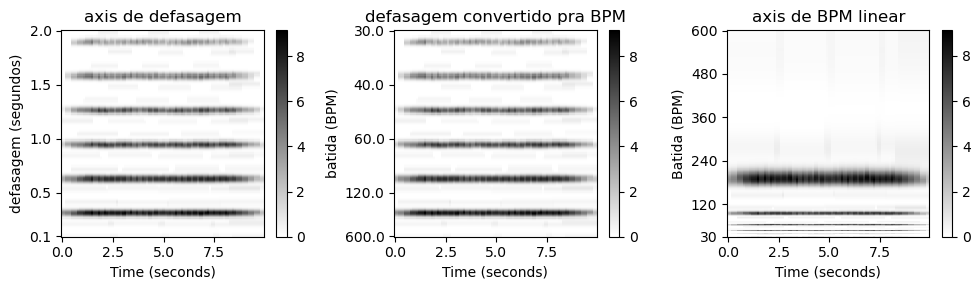

In [10]:
#@jit(nopython=True)
def compute_tempogram_autocorr(x, Fs, N, H, norm_sum=False, Theta=np.arange(30, 601)):
    """ Calcula o tempograma baseado em autocorrelação
    Args:
        x (np.ndarray): Sinal de entrada
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
        norm_sum (bool): Normaliza pelo número de parcelas na autocorrelação local (Valor padrão = False)
        Theta (np.ndarray): Conjunto de tempos (dados em BPM) (Valor padrão = np.arange(30, 601))
    Retorna:
        tempogram (np.ndarray): Tempograma
        T_coef (np.ndarray): Eixo temporal T_coef (segundos)
        F_coef_BPM (np.ndarray): Eixo de tempo F_coef_BPM (BPM)
        A_cut (np.ndarray): Representação do atraso temporal A_cut (cortado de acordo com Theta)
        F_coef_lag_cut (np.ndarray): Eixo de atraso F_coef_lag_cut """
    # Calcula os limites de tempo e atraso com base em Theta
    tempo_min = Theta[0]
    tempo_max = Theta[-1]
    lag_min = int(np.ceil(Fs * 60 / tempo_max))
    lag_max = int(np.ceil(Fs * 60 / tempo_min))
    
    # Calcula a autocorrelação local
    A, T_coef, F_coef_lag = compute_autocorrelation_local(x, Fs, N, H, norm_sum=norm_sum)
    
    # Corta a matriz A de acordo com os limites de atraso calculados
    A_cut = A[lag_min:lag_max+1, :]
    F_coef_lag_cut = F_coef_lag[lag_min:lag_max+1]
    
    # Calcula o eixo de BPM (batimentos por minuto) correspondente aos atrasos cortados
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    
    # Interpola os resultados para obter o tempograma final
    tempogram = interp1d(F_coef_BPM_cut, A_cut, kind='linear',
                         axis=0, fill_value='extrapolate')(Theta)
    
    return tempogram, T_coef, Theta, A_cut, F_coef_lag_cut

Theta = np.arange(30, 601)
tempogram, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, Fs_nov, N, H, norm_sum=False, Theta=Theta)

fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=(10,3)) 

libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, ax=[ax[0]], title='axis de defasagem', ylabel='defasagem (segundos)', colorbar=True);
lag_yticks = np.array([F_coef_lag[0], 0.5, 1.0, 1.5, F_coef_lag[-1]])
ax[0].set_yticks(lag_yticks)

libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, ax=[ax[1]],title='defasagem convertido pra BPM', ylabel='batida (BPM)', colorbar=True);
ax[1].set_yticks(lag_yticks)
ax[1].set_yticklabels(60/lag_yticks)

libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef, ax=[ax[2]], title='axis de BPM linear', ylabel='Batida (BPM)', colorbar=True);
ax[2].set_yticks([F_coef[0], 120, 240, 360, 480, F_coef[-1]]);
plt.tight_layout()

### tempos harmônicos e sub-harmônicos

A seguir, ilustramos esses conceitos considerando uma trilha de cliques com aumento de tempo . Este exemplo ilustra que um tempograma de autocorrelação exibe sub-harmônicas de tempo, enquanto suprime harmônicas de tempo. A razão para esse comportamento é que uma alta correlação de uma seção local da função de novidade com a seção deslocada por $\ell$ amostras também implica uma alta correlação com uma seção deslocada por $k \cdot \ell$ defasagens para inteiros $k \in \mathbb{N}$. Supondo que $\ell$ corresponda ao tempo $\tau$, a defasagem $k \cdot \ell$ corresponde à sub-harmônica $\tau / k$. Note que esse comportamento contrasta com o tempograma de Fourier, que enfatiza as harmônicas de tempo, mas suprime as sub-harmônicas de tempo.

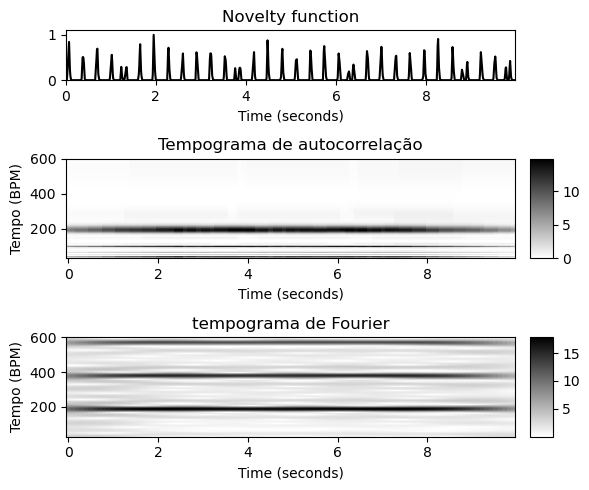

In [11]:
fn_wav = os.path.join( 'Audios', 'Luv(sic)_Part_3.mp3')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=1)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
tempogram_A, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, Fs_nov, N, H, norm_sum=False, Theta=Theta)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2, 2]}, figsize=(6,5))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram_A, T_coef=T_coef, F_coef=F_coef, ax=[ax[1,0], ax[1,1]], title='Tempograma de autocorrelação', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,5));


X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram_F = np.abs(X)

libfmp.b.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[2,0], ax[2,1]],  title='tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,5))
plt.tight_layout()